## The Image Captioning
- Generating Caption for Images

## Steps 
- Data Collection
- Understanding The Data
- Data Cleaning
- Loading The Training Set
- Data Preprocessing -- Images
- Data Preprocessing -- Captions
- Data Preparation Using Generator Function
- Word Embedding
- Model Architecture
- Inference 
- Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
# Read Text Captions
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [3]:
captions=readTextFile("./Flickr8k_text/Flickr8k.token.txt")
# print(captions) we cant print all data
# split everything about newline character to get total captions
captions=captions.split("\n")[:-1] # [:-1] discards last string bz its an empty string

In [4]:
print(captions[0])# prints 0th captions
print(len(captions))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
40460


In [5]:
first,second=captions[0].split('\t') #Note in Each entry in the file '\t' splits image id and caption 
print(first)
print(second)
print(first.split('.'))# The left part will act as a key to dictionary entry 

1000268201_693b08cb0e.jpg#0
A child in a pink dress is climbing up a set of stairs in an entry way .
['1000268201_693b08cb0e', 'jpg#0']


### Dictionary to Map each image with the list of captions it has

In [6]:
descriptions={}

In [7]:
# Note img id and caption is separated by \t
for x in captions:
    first,second=x.split('\t')
    img_name=first.split('.')[0]
    # if the image id is not present
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[] # if img_name does not exist create a empty new list for the image
    descriptions[img_name].append(second)
    

In [8]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
import cv2
import matplotlib.pyplot as plt

In [10]:
img_path="Flickr8k_Dataset/Flicker8k_Dataset/"

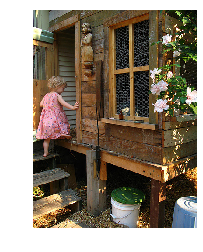

In [11]:
img=cv2.imread(img_path+"1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning

In [12]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 

def clean_text(sentence):
    sentence=sentence.lower() 
    sentence=re.sub("[^a-z]+"," ",sentence) 
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1] # we remove a word of length 1 you can try it 
    sentence=" ".join(sentence)
    return sentence   

In [13]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34 asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [14]:
#Clean All Captions
# modify all the captions i.e - cleaned captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [15]:
descriptions["1000268201_693b08cb0e"] # cleaned captions for an image

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [16]:
# writing clean description to .txt file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary

In [17]:
# reading description file
descriptions=None
f=open("descriptions.txt",'r')
descriptions=f.read()
f.close()

# To convert this string to Python dictionary we will Json Python Library 
json_acceptable_string = descriptions.replace("'", "\"")
descriptions=json.loads(json_acceptable_string)

In [18]:
print(type(descriptions))

<class 'dict'>


In [19]:
descriptions["1000268201_693b08cb0e"] # Json dictinary output

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [20]:
# Making Vocab 
# finding the unique vocabulary 
vocabulary=set()
for key in descriptions.keys():
    [vocabulary.update(sentence.split()) for sentence in descriptions[key]] # list comprehension
print('Vocabulary Size:%d'%len(vocabulary))

Vocabulary Size:8424


In [21]:
#  ALl words in description dictionary
all_vocab=[] # contains all words
for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]
print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [22]:
import collections

In [23]:
counter=collections.Counter(all_vocab)
freq_cnt=dict(counter)
#print(freq_cnt)
print(len(freq_cnt.keys()))

8424


In [24]:
# Filter Words from the vocab to minimise vocab size according to some threshold
# count the frequency of each word,sort them and discard the words having frequency lesser than threshold value
counter=collections.Counter(all_vocab)
dic_=dict(counter)
threshelod_value=10
# sort the dictionary according to freq_cnt
sorted_dic=sorted(dic_.items(),reverse=True,key=lambda x:x[1]) # actaully its a list
# Filter
sorted_dic=[x for x in sorted_dic if x[1]>threshelod_value]
# vocab of words frequency greater than 10
all_vocab=[x[0] for x in sorted_dic]

In [25]:
#print(sorted_dic)

In [26]:
print(len(all_vocab))

1845


### Prepare Train/Test Data

In [27]:
train_file_data=readTextFile('Flickr8k_text/Flickr_8k.trainImages.txt')
test_file_data=readTextFile('Flickr8k_text/Flickr_8k.testImages.txt')

In [28]:
# remove .jpg from image name and also remove '\n'
train=[row.split('.')[0] for row in train_file_data.split("\n")[:-1]]
print(train[:10])
# same for test file
test=[row.split('.')[0] for row in test_file_data.split("\n")[:-1]]
print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [29]:
# Prepare Description for the Training Data
# Tweak Add <s> and <e> token to our training data
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id]=[]
    # adding <s> and <e> token to each caption of train img_id getting captions from original Descriptions dict
    for cap in descriptions[img_id]:
        cap_to_append="startseq "+cap+" endseq"
        train_descriptions[img_id].append(cap_to_append)

In [30]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning  (for Image Processing)
- Images - -> Features
- Text --> Features

## Step -1- Image Feature Extraction
"""
In this section, we will load our images and do some processing so that we can feed it in our network.
"""

In [34]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3)) # This model is already initialised with the weights called imagenet

102858752/102853048 [==============================] - 837s 8us/step


In [35]:
model.summary() # it has one more column 'connected to' . It says to which layer a layer is connected to 
# bz we are using here ResNet model which has skip connections which is not in the case of SEQUENTIAL model.
# These skip connecttions allows deep network to learn without facing the issue of vanishing gradient.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [36]:
# The activation_98 layer gives 7X7X2048 neurons which means large number of neurons in the dense layer finally 
# reults in large parameters( Heavy weights). One way is we r going to squeeze every channel  and take avg of all 
# rsulting a single neuron so you will get a list of 2048 numbers . Basically these 2048 numbers are going to tell
# what features are present in the image if one neuron has higher activation means this feature is present in the 
# image and vice versa. SO THESE 2048 VALUES WILL BE THE FEATURE REPRSENTATION OF OUR IMAGE.

In [37]:
model.layers[-2].output

<tf.Tensor 'avg_pool_2/Mean:0' shape=(?, 2048) dtype=float32>

In [38]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
# Output comes from the AverageGlobalPoolingLayer2
model_new = Model(model.input, model.layers[-2].output)

In [39]:
# Preprocessing the image before feeding to the Model
# Preporocess means extracting the features from the images and save it to a file.
def preprocess_image(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img, axis=0) # expand dims to 4D tensor bz we will feed a batch of image not a single so
    # (224,224,3) X batch gives 4D. this fuction will automatically solve this issue. So u can use reshape here
    
    #Normalisation
    img=preprocess_input(img)
    
    return img

In [40]:
img=preprocess_image(img_path+"1000268201_693b08cb0e.jpg") #preprocessing 1 image

In [41]:
print(img.shape)

(1, 224, 224, 3)


W0329 16:48:10.804162 140161603626816 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


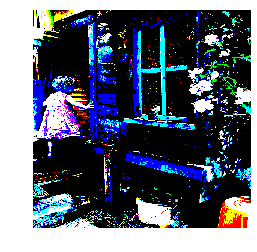

In [42]:
plt.axis('off')
plt.imshow(img[0]) # this image is looking like this by plotlib bz pixel values are less than 0 
# it is so bz Resnet might normalised it with channel mean instead of /255. But it is will not affect our result. 

In [43]:
# Function to preprocess all the images
def encode_image(img):
    img=preprocess_image(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,)) # converting scalar
    return feature_vector

In [44]:
encode_image(img_path+"1000268201_693b08cb0e.jpg")

array([0.04154316, 0.1707608 , 0.2927861 , ..., 0.05089623, 0.31322378,
       0.86007535], dtype=float32)

In [45]:
start=time()
# this dictionary will store image_id-->feature vector extracted from ResNet50
encoding_train={}
# train is list 
for ix,img in enumerate(train):
    img=img_path+"/"+img_id+".jpg"
    encoding_train[img]=encode_image(img)
    # every 100th image i check progress
    if ix%100==0:
        print("Encoding image- "+str(ix))    
print("Time taken in seconds =",time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Encoding image- 1000
Encoding image- 1100
Encoding image- 1200
Encoding image- 1300
Encoding image- 1400
Encoding image- 1500
Encoding image- 1600
Encoding image- 1700
Encoding image- 1800
Encoding image- 1900
Encoding image- 2000
Encoding image- 2100
Encoding image- 2200
Encoding image- 2300
Encoding image- 2400
Encoding image- 2500
Encoding image- 2600
Encoding image- 2700
Encoding image- 2800
Encoding image- 2900
Encoding image- 3000
Encoding image- 3100
Encoding image- 3200
Encoding image- 3300
Encoding image- 3400
Encoding image- 3500
Encoding image- 3600
Encoding image- 3700
Encoding image- 3800
Encoding image- 3900
Encoding image- 4000
Encoding image- 4100
Encoding image- 4200
Encoding image- 4300
Encoding image- 4400
Encoding image- 4500
Encoding image- 4600
Encoding image- 4700
Enco

In [118]:
# Save the bottleneck train features to disk
with open("encoded_train_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_train,encoded_pickle)

In [119]:
# Load the train images features from disk

with open("encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [84]:
start=time()
# this dictionary will store image_id-->feature vector extracted from ResNet50
encoding_test={}
# train is list 
for ix,img in enumerate(test):
    img=img_path+"/"+img_id+".jpg"
    encoding_test[img]=encode_image(img)
    # every 100th image i check progress
    if ix%100==0:
        print("Encoding image- "+str(ix))    
print("Time taken in seconds =",time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Time taken in seconds = 257.3631546497345


In [85]:
# Save the bottleneck train features to disk
with open("encoded_test_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [121]:
# Load the test images features from disk

with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

### Data PreProcessing for the Captions

In [122]:
# Our final words wer 1845
len(all_vocab)

1845

In [123]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""
ix=1
word_to_idx={}
idx_to_word={}

for i,word in enumerate(all_vocab):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word # we will reserve the index 0 

In [124]:
print(word_to_idx['dog'])  # DOG IS AT INDEX 6
print(idx_to_word[6])

6
dog


In [125]:
#need to add these 2 words as well
word_to_idx['startseq']=1846
word_to_idx['endseq']=1847
idx_to_word[1846]='startseq'
idx_to_word[1847]='endseq'

In [126]:
#vocab_size is total vocabulary len +1 because we will append 0's as well. 
vocab_size=len(idx_to_word)+1
print(vocab_size)

1848


In [127]:
# fINDING MAXIMUM LENGTH CAPTION IN OUR TRAIN IMAGES
max_len=0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)# so maxlength of any caption for train images is 35 

35


In [52]:
## To get knowledge about why we need Data Generator
## https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

## Data Loader(Generator)

### Data Preparation USing Data Generator

In [128]:
# 
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,num_photos_per_batch):
    # in X1 we store photo dimension(2048)
    # in X2 we store X data points (1845)
    # in y we store 1 hot vector which is our Vocab Size
    X1, X2, y = [], [], []
    n=0 # n denotes no of training points in our batch
    while True: 
        # key is img_id and desc_list is caption list 
        for key, desc_list in train_descriptions.items():
            n +=1
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                # seq of numbers corresponding to the ith caption of the image 
                # if word is not in vocab simply ignore it
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    xi = seq[0:i]
                    yi = seq[i]
                    # padding xi so that every xi is of same length 0 denotes pad and pad_sequences is from keras
                    # pad_sequences accept 2D so it returns 2D and hence we use [0] to extract correct in_seq
                    xi = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # so we get 1 training point
                    # append this to our mini batch
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

### Word Embedding

In [129]:
f=open("glove.6B.50d.txt",encoding='utf8')

In [130]:
embedding_index={} #stores the vector for every word
for line in f:
    values=line.split() # every line in glove file has a word and 50 integers numbers associated with it
    word=values[0] # word 
    coefs=np.asarray(values[1:],dtype="float") # all 50 numbers
    embedding_index[word]=coefs # prepare the embedding_index
f.close()

In [58]:
#embedding_index['apple']

### Converting Words into  vectors Directly- (Embedding Layer Output)

In [131]:
def get_embedding_output():
    emb_dim=50
    embedding_output=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            embedding_output[idx]=embedding_vector
        # if embedding vector is none then embedding matrix output will contain all zeors for that word
    return embedding_output


In [132]:
embedding_output = get_embedding_output()

In [133]:
print(embedding_output.shape)

(1848, 50)


In [134]:
print(embedding_output[1847]) #prints all 0 as startseg or endseq are not there in embedding index bz they are 
# not in glove.6B.50d.txt file

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


### Model Architecture

In [135]:
# image feature extractor model
input_img_fea=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_fea)# mentioned in () are input to present layer
inp_img2=Dense(256,activation='relu')(inp_img1) # inp_img1 is the input for this dense layer

In [136]:
# partial caption sequence model

input_cap=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [137]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


In [138]:
# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [139]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 50)       92400       input_9[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_8[0][0]                    
__________________________________________________________________________________________________
dropout_6 

In [140]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [141]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

### Train Our Model

In [142]:
epochs=10
number_pics_per_bath=3
steps=len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,number_pics_per_bath)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('model_9'+str(i) + '.h5')

In [143]:
model=load_model("model_9.h5") #load weights so that we can predict these are loads after 10 epoch

### Predictions

In [144]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence=pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred=model.predict([photo,sequence])
        ypred=ypred.argmax() # Word With max Possibility (Greedy Sampling)
        word=idx_to_word[ypred] # GEt actual Word
        in_text+=' '+word # append to in_text
        
        if word=='endseq': # we can break as end seq is found
            break
        
        
    final_caption=in_text.split()
    final_caption=final_caption[1:-1]
    final_caption=' '.join(final_caption)
    
    return final_caption

In [145]:
all=list(encoding_test.keys())

In [146]:
len(all)

1000

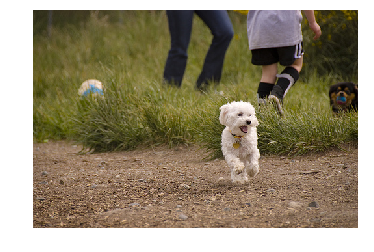

two dogs are running in field


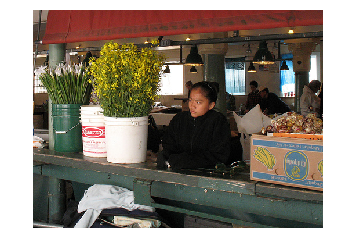

man and woman sit on bench in front of restaurant


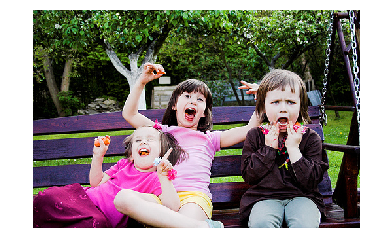

two girls pose for picture


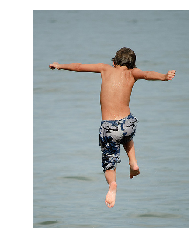

young boy in swimming trunks is running in the water


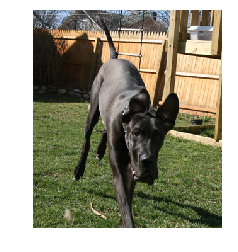

black and white dog is jumping over hurdle


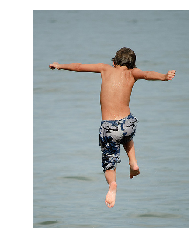

young boy in swimming trunks is running in the water


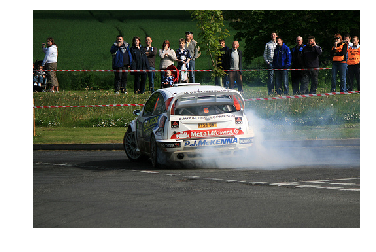

race car is driving through the mud


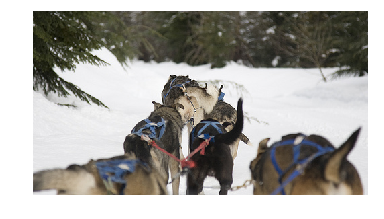

two dogs are running through the grass


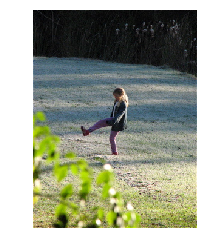

young girl in green shirt is running through field of grass


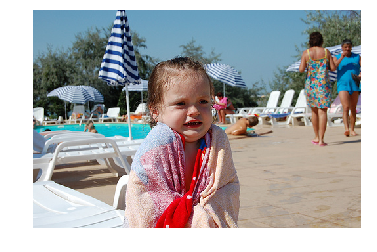

woman in black shirt and backpack is standing on the street


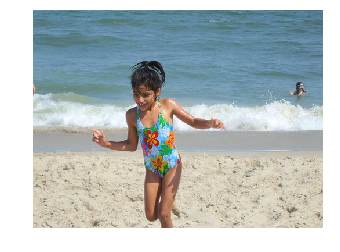

young girl jumping in the ocean


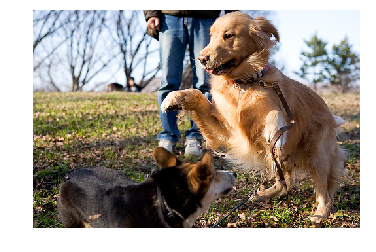

two dogs are playing together in the grass


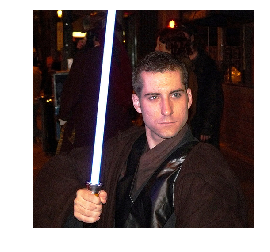

man with his hand around his head and holding his hand and looking at the camera


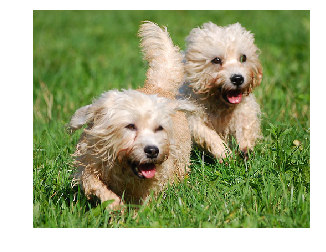

dog is playing with toy in the grass


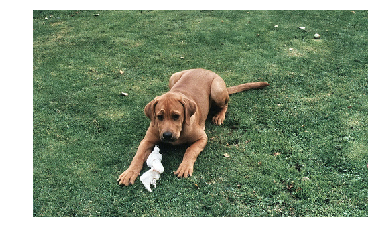

brown dog is running through the grass


In [155]:
# Pick Some random images and see results
for i in range(15):
    idx=np.random.randint(0,1000)
    all_img_names=list(encoding_test.keys())
    img_name=all_img_names[idx]
    photo=encoding_test[img_name].reshape((1,2048))

    i=plt.imread("Images/"+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption=predict_caption(photo)
    print(caption)